# Week 7 Assessment
This notebook contains two parts:

- **Part A (Classification):** Titanic Dataset with non-linear models (KNN & Decision Tree).
- **Part B (Regression):** Housing Prices Dataset with non-linear models (Decision Tree Regressor & Random Forest).

We perform baseline modeling, hyperparameter tuning (GridSearchCV & RandomizedSearchCV), and compare results.


## Part A: Classification (Titanic Dataset)

In [1]:

# === Load Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import randint
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# === Load Titanic Dataset ===
titanic = pd.read_csv("../data/Titanic-Dataset.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:

# === Preprocess Titanic Data ===
def preprocess_data(df):
    df = df.copy()
    df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
    df.fillna({"Fare": df["Fare"].median()}, inplace=True)
    df.drop(columns=["Embarked"], inplace=True)
    # df["Age"].fillna(df["Age"].median(), inplace=True)
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Sex"] = df["Sex"].map({"male":1, "female":0})
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    df["IsAlone"] = np.where(df["FamilySize"] == 0, 1, 0)
    return df

In [4]:
titanic = preprocess_data(titanic)

In [5]:
X = titanic.drop(columns=["Survived"])
y = titanic["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:

# === Baseline KNN ===
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Baseline KNN Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Baseline KNN Accuracy: 0.8071748878923767
              precision    recall  f1-score   support

           0       0.81      0.88      0.85       134
           1       0.79      0.70      0.74        89

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.81      0.81      0.80       223



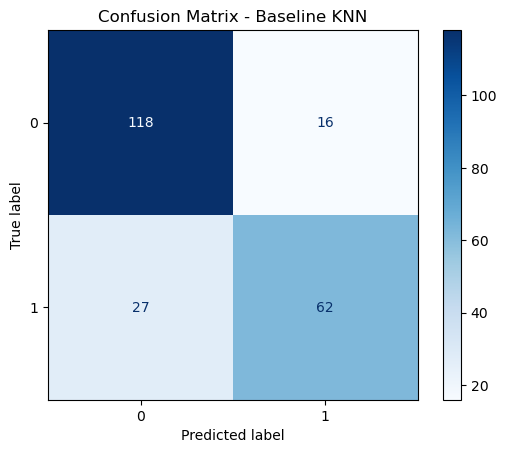

In [8]:

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Baseline KNN")
plt.show()


In [9]:

# === Hyperparameter Tuning: GridSearchCV (KNN) ===
param_grid = {
    "n_neighbors": range(1, 21),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best GridSearchCV Params:", grid.best_params_)
y_pred_grid = grid.predict(X_test)
print("Tuned KNN Accuracy (GridSearchCV):", accuracy_score(y_test, y_pred_grid))


Best GridSearchCV Params: {'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'uniform'}
Tuned KNN Accuracy (GridSearchCV): 0.7937219730941704


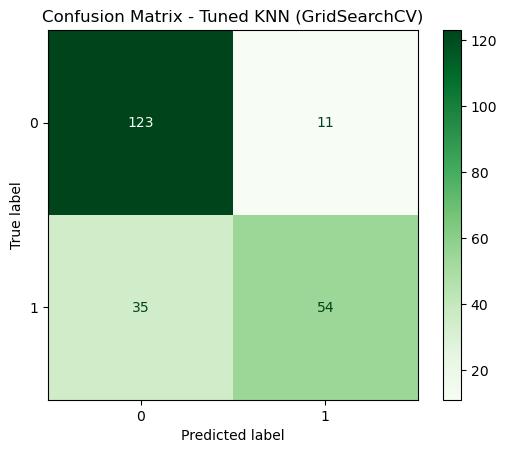

In [10]:
ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test, y_test, cmap="Greens")
plt.title("Confusion Matrix - Tuned KNN (GridSearchCV)")
plt.show()

In [11]:

# === Hyperparameter Tuning: RandomizedSearchCV (KNN) ===
param_dist = {
    "n_neighbors": randint(1, 21),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}
rand = RandomizedSearchCV(KNeighborsClassifier(), param_dist, cv=5, n_iter=10, n_jobs=-1, random_state=42)
rand.fit(X_train, y_train)
print("Best RandomizedSearchCV Params:", rand.best_params_)
y_pred_rand = rand.predict(X_test)
print("Tuned KNN Accuracy (RandomizedSearchCV):", accuracy_score(y_test, y_pred_rand))


Best RandomizedSearchCV Params: {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}
Tuned KNN Accuracy (RandomizedSearchCV): 0.7892376681614349


In [12]:

# === Decision Tree Classifier ===
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


Decision Tree Accuracy: 0.757847533632287
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       134
           1       0.71      0.67      0.69        89

    accuracy                           0.76       223
   macro avg       0.75      0.74      0.75       223
weighted avg       0.76      0.76      0.76       223



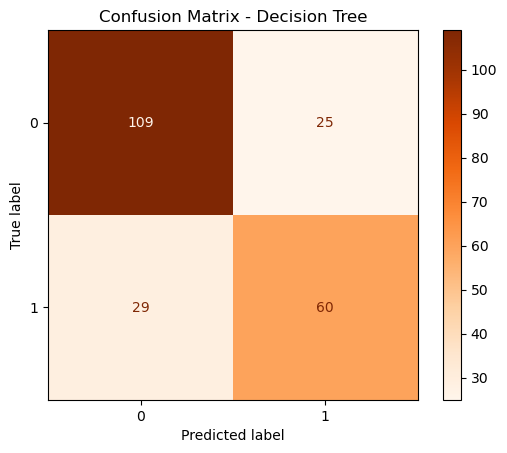

In [13]:
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, cmap="Oranges")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

#### Model Performance Comparison (bar chart)

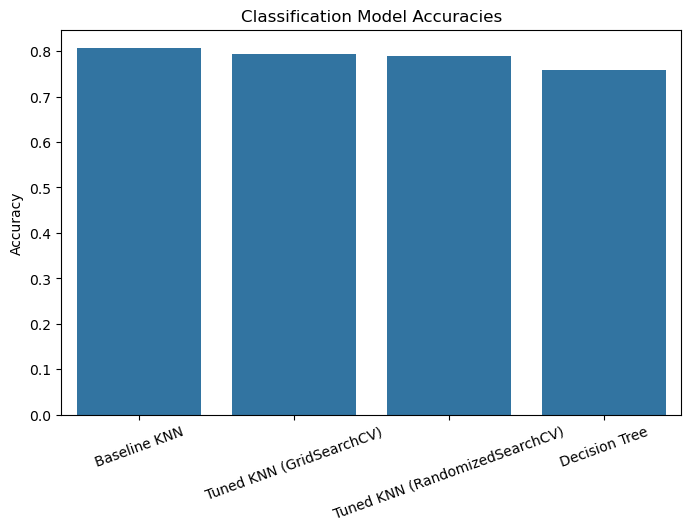

In [14]:
results_class = {
    "Baseline KNN": accuracy_score(y_test, y_pred),
    "Tuned KNN (GridSearchCV)": accuracy_score(y_test, y_pred_grid),
    "Tuned KNN (RandomizedSearchCV)": accuracy_score(y_test, y_pred_rand),
    "Decision Tree": accuracy_score(y_test, y_pred_tree)
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(results_class.keys()), y=list(results_class.values()))
plt.title("Classification Model Accuracies")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()

## Part B: Regression (Housing Prices Dataset)

In [15]:

# === Load Housing Dataset ===
housing = pd.read_csv("../data/housing_data.csv")
housing.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [16]:

# === Preprocess Housing Data ===
# Keep only numeric features, drop columns with NaN for simplicity
housing = housing.select_dtypes(include=[np.number]).dropna(axis=1)
X = housing.drop(columns=["price"], errors="ignore")
y = housing["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [17]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

# === Baseline Decision Tree Regressor ===
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
y_pred = dt_reg.predict(X_test)
print("Baseline Decision Tree R2:", r2_score(y_test, y_pred))
# print("Baseline Decision Tree RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Baseline Decision Tree RMSE:", root_mean_squared_error(y_test, y_pred))

Baseline Decision Tree R2: -0.04778968748649981
Baseline Decision Tree RMSE: 2197378.865594616


#### Predicted vs Actual Scatter Plots

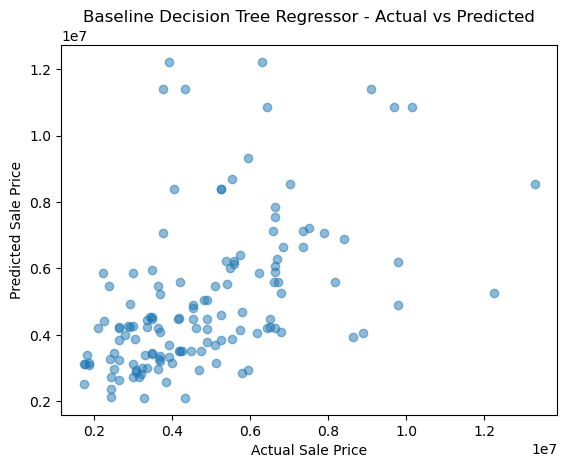

In [28]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Baseline Decision Tree Regressor - Actual vs Predicted")
plt.show()

In [19]:

# === Hyperparameter Tuning: GridSearchCV (Decision Tree Regressor) ===
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
grid = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best GridSearchCV Params:", grid.best_params_)
y_pred_grid = grid.predict(X_test)
print("Tuned Decision Tree R2:", r2_score(y_test, y_pred_grid))
print("Tuned Decision Tree RMSE:", root_mean_squared_error(y_test, y_pred_grid))


Best GridSearchCV Params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tuned Decision Tree R2: 0.24811464440230135
Tuned Decision Tree RMSE: 1861417.0876476965


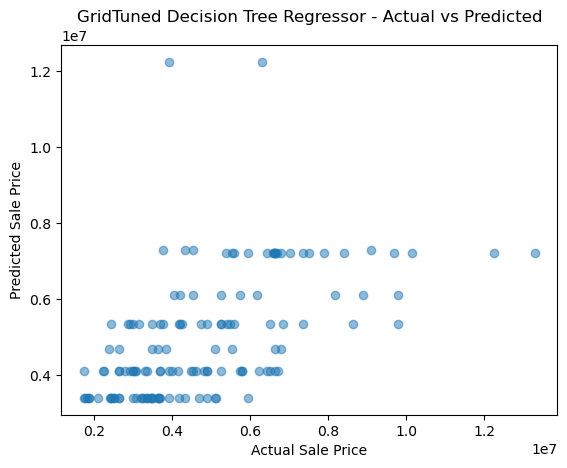

In [29]:
plt.scatter(y_test, y_pred_grid, alpha=0.5)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("GridTuned Decision Tree Regressor - Actual vs Predicted")
plt.show()


In [22]:

# === Hyperparameter Tuning: RandomizedSearchCV (Decision Tree Regressor) ===
param_dist = {
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10)
}
rand = RandomizedSearchCV(DecisionTreeRegressor(random_state=42), param_dist, cv=5, n_iter=10, n_jobs=-1, random_state=42)
rand.fit(X_train, y_train)
print("Best RandomizedSearchCV Params:", rand.best_params_)
y_pred_rand = rand.predict(X_test)
print("Tuned Decision Tree (RandomizedSearchCV) R2:", r2_score(y_test, y_pred_rand))
print("Tuned Decision Tree (RandomizedSearchCV) RMSE:", root_mean_squared_error(y_test, y_pred_rand))


Best RandomizedSearchCV Params: {'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 13}
Tuned Decision Tree (RandomizedSearchCV) R2: 0.4322683413171775
Tuned Decision Tree (RandomizedSearchCV) RMSE: 1617481.9376341968


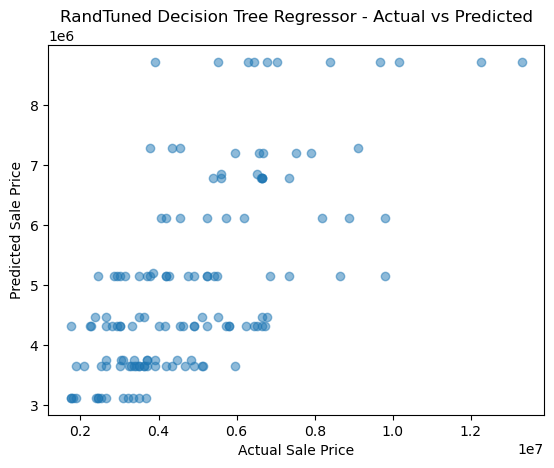

In [30]:
plt.scatter(y_test, y_pred_rand, alpha=0.5)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("RandTuned Decision Tree Regressor - Actual vs Predicted")
plt.show()

In [24]:

# === Random Forest Regressor ===
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", root_mean_squared_error(y_test, y_pred_rf))


Random Forest R2: 0.40268627626102416
Random Forest RMSE: 1659086.8833868494


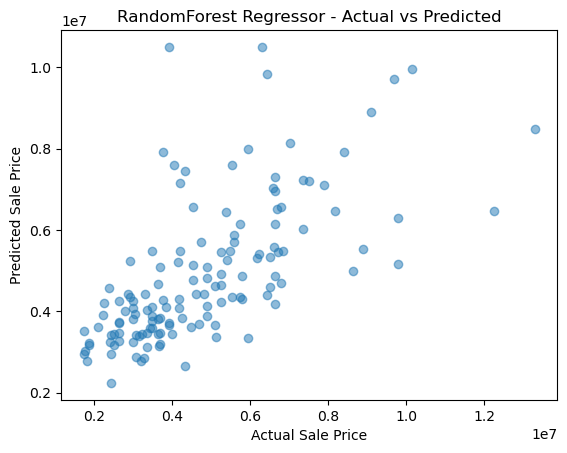

In [31]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("RandomForest Regressor - Actual vs Predicted")
plt.show()


#### Model Performance Comparison (bar chart)

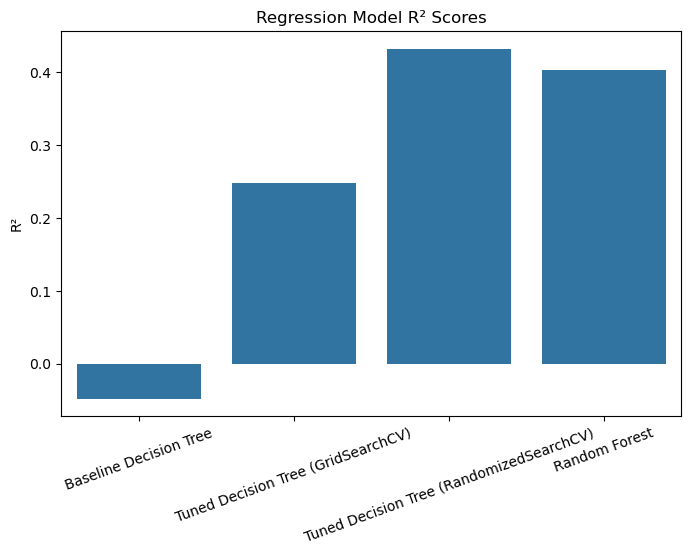

In [32]:
results_reg = {
    "Baseline Decision Tree": r2_score(y_test, y_pred),
    "Tuned Decision Tree (GridSearchCV)": r2_score(y_test, y_pred_grid),
    "Tuned Decision Tree (RandomizedSearchCV)": r2_score(y_test, y_pred_rand),
    "Random Forest": r2_score(y_test, y_pred_rf)
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(results_reg.keys()), y=list(results_reg.values()))
plt.title("Regression Model R² Scores")
plt.ylabel("R²")
plt.xticks(rotation=20)
plt.show()
